# Steps: 

0. Change runtime to GPU

1. Resize the source images to h=256, w=192, and place them in my-source-input-images and in dataset/images folder of down-to-the-last-detail-with-detail-carving.

2. Generate openpose json of these resized images and place them in dataset/pose_coco of down-to-the-last-detail-with-detail-carving.

3. Select the cloth image, resize it to (h=256, w=192) and place it in cloth folder of down-to-the-last-detail-with-detail-carving.

4. Generate the cloth mask of the resized cloth image using grabcut, and place it in cloth_mask folder of down-to-the-last-detail-with-detail-carving.

5. Copy the resized images to images folder of my-source-input-images to images folder of $HOME/datasets/CIHP/

6. Generate edges and labels using the code written and place them in CIHP/edges and CIHP/lables.

7. To generate output of semantic parsing, update val.txt in list folder and val_id.txt.

8. Run test_pgn.py and copy the output image in cihp_parsing_maps in format {image_name}_vis.png to parse_cihp of  down-to-the-last-detail-with-detail-carving.

9. Copy the label input images to parse_cihp of down-to-the-last-detail-with-detail-carving.

10. Ensure all the input images are of size: h=256, w=192.

11. Update the image names in demo.txt of down-to-the-last-detail-with-detail-carving.

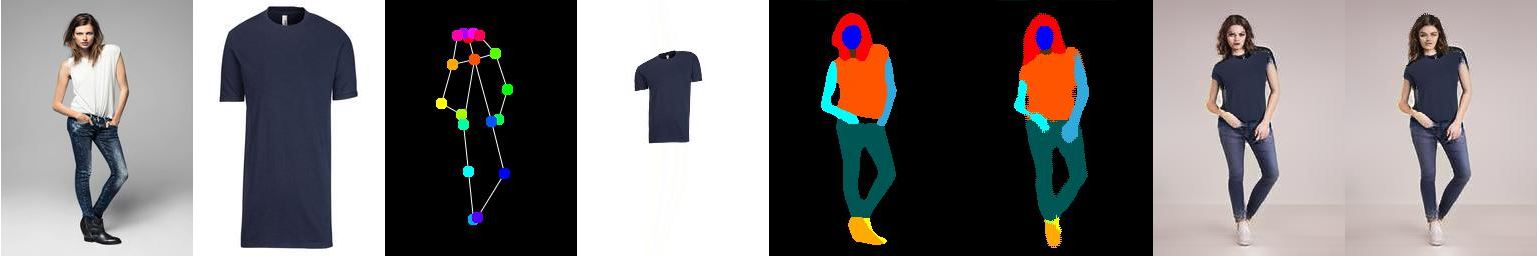

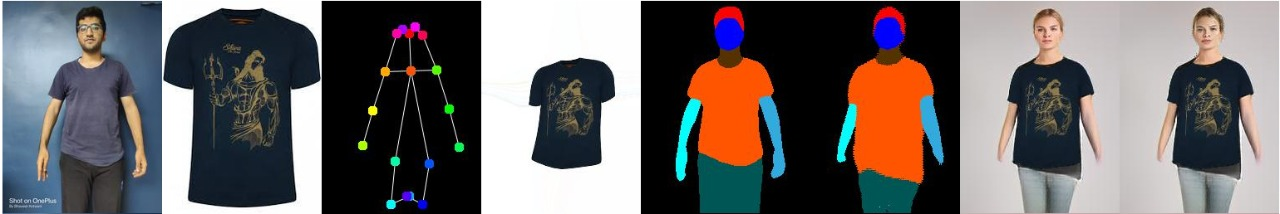

# Current Status

In [ ]:
# The computation ability and gpu memory maybe not enough for gtx 1050. Computational overhead differs in different training stages. 32GB or more GPU memory would be better.

# directly retrain the model following the guidance in the train.sh step by step.
#The default training epoch is 200, but emperically GMM model optimizes more quickly. The difference in the red circle is mainly caused by GMM and parsing transformation part. You can train this part for more iterations to find out if it can be better.
#Our training procedure of GMM is similar to VITON and CPVTON, which your can refer to for more details of this part.

#1.you can't use it for bigger resolution, most of the vton system available works for small resolution.
#2. The face part blends 2 faces from the source and target image using a face network, check out the paper
#3.the better the output of predicted segmentation map the better the gan output
#4.Qulality of the output depends on the data trained and the difficulty of poses.

#Currently the pretrained model only supports the women face since the people in the dataset used in our experiments are almost female.


'''
Hi, maybe the main reason of unreasonable results is the domain difference between the testing images and training dataset(MPV), 
where the background of person images are more simple(gray or white). Besides, some kinds of cloth types, such as the long women coat, jacket, 
are seldom appears in the training set we used. Perhaps recollecting more diverse data following the MPV structure, and retraining the model could hleps. 
For the complex background, processing the foreground(person) and background separately maybe a method if you want the generated image shares the same background with the source image.
'''

# Resize Images

In [ ]:
# Multiple Images
# Resize input images to (256,192)
from PIL import Image
import os, sys
#Place your input images here to be resized to (256,192)
%cd '/content/drive/My Drive/Eroom-models-working/images'
path = ('/content/drive/My Drive/Eroom-models-working/images')

def resize():
  for item in os.listdir(path):
      if os.path.isfile(item):
          im = Image.open(item)
          f, e = os.path.splitext(item)
          imResize = im.resize((192,256), Image.ANTIALIAS)
          imResize.save(f+'.jpg', 'JPEG', quality=90)

resize()

/content/drive/My Drive/Eroom-models-working/images


In [ ]:
# Person Image
import PIL
import matplotlib.pyplot as plt
%matplotlib inline
image = PIL.Image.open('/content/priyu.jpeg')
print(image.size)
plt.imshow(image)
plt.show()
resized_image = image.resize((192,256),PIL.Image.LANCZOS)
print(resized_image.size)
plt.imshow(resized_image)
plt.show()
resized_image.save('/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/images/priyu.jpg')

In [ ]:
# Cloth Image
import PIL
import matplotlib.pyplot as plt
%matplotlib inline
image = PIL.Image.open('/content/s-2.jpg')
print(image.size)
plt.imshow(image)
plt.show()
resized_image = image.resize((192,256),PIL.Image.LANCZOS)
print(resized_image.size)
plt.imshow(resized_image)
plt.show()
resized_image.save('/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/cloth_image/s-2.jpg')


# Simple-HRNET to Openpose json output

In [ ]:
#Working Directory
%cd '/content/drive/My Drive/Eroom-models-working/simple-HRNet'
import cv2
from SimpleHRNet import SimpleHRNet
import pandas as pd
import numpy as np


#Run Simple-HRNET
model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth")
img=cv2.imread('/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/images/1XC23D02N-Q12@12=person_half_front.jpg')
#img1=cv2.resize(img, (192,256), cv2.INTER_CUBIC)
joints = model.predict(img)


#### Input: HRNET joints, OUTPUT: Openpose Json
raw_joints = pd.DataFrame(joints[0])#input
columns_titles = [1,0]
raw_joints2=raw_joints.reindex(columns=columns_titles)
raw_joints2 = pd.concat([raw_joints2,raw_joints[2]], axis=1)
raw_joints2

openpose_json = pd.DataFrame(raw_joints2.iloc[0]).T
x_av = (raw_joints2.loc[5,1] +  raw_joints2.loc[6,1])/2
y_av = (raw_joints2.loc[5,0] +  raw_joints2.loc[6,0])/2
z_av = (raw_joints2.loc[5,2] +  raw_joints2.loc[6,2])/2

openpose_json=openpose_json.append({1:x_av,0:y_av,2:z_av},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[6,1],0:raw_joints2.loc[6,0],2:raw_joints2.loc[6,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[8,1],0:raw_joints2.loc[8,0],2:raw_joints2.loc[8,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[10,1],0:raw_joints2.loc[10,0],2:raw_joints2.loc[10,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[5,1],0:raw_joints2.loc[5,0],2:raw_joints2.loc[5,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[7,1],0:raw_joints2.loc[7,0],2:raw_joints2.loc[7,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[9,1],0:raw_joints2.loc[9,0],2:raw_joints2.loc[9,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[12,1],0:raw_joints2.loc[12,0],2:raw_joints2.loc[12,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[14,1],0:raw_joints2.loc[14,0],2:raw_joints2.loc[14,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[16,1],0:raw_joints2.loc[16,0],2:raw_joints2.loc[16,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[11,1],0:raw_joints2.loc[11,0],2:raw_joints2.loc[11,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[13,1],0:raw_joints2.loc[13,0],2:raw_joints2.loc[13,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[15,1],0:raw_joints2.loc[15,0],2:raw_joints2.loc[15,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[2,1],0:raw_joints2.loc[2,0],2:raw_joints2.loc[2,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[1,1],0:raw_joints2.loc[1,0],2:raw_joints2.loc[1,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[4,1],0:raw_joints2.loc[4,0],2:raw_joints2.loc[4,2]},ignore_index=True)
openpose_json=openpose_json.append({1:raw_joints2.loc[3,1],0:raw_joints2.loc[3,0],2:raw_joints2.loc[3,2]},ignore_index=True)

input_json = openpose_json.to_numpy().flatten().tolist() #output, openpose coco keypoints

import json 
%cd '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/pose_coco'
# Data to be written 
dictionary ={ 
"version":1.3,"people":[{"person_id":[-1],"pose_keypoints_2d":input_json,"face_keypoints_2d":[],"hand_left_keypoints_2d":[],"hand_right_keypoints_2d":[],"pose_keypoints_3d":[],"face_keypoints_3d":[],"hand_left_keypoints_3d":[],"hand_right_keypoints_3d":[]}]
} 
# Serializing json  
json_object = json.dumps(dictionary) 
  
# Writing to sample.json 
with open("1XC23D02N-Q12@12=person_half_front_keypoints.json", "w") as outfile: #json output file
    outfile.write(json_object) 


/content/drive/.shortcut-targets-by-id/298/simple-HRNet
device: 'cpu'
/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/pose_coco


# Semantic Parsing

First you need to run a matpltlib script to produce label, and edge inputs from source images, and then copy the labelimage(input label image generated by running matplotlib script), and {IMAGE_NAME}_vis.png output image to  "/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/parse_cihp"

In [ ]:
%cd '/content/drive/My Drive/Eroom-models-working/$HOME'
#Run matplotlib script to produce labels, and edges from new source image in datasets/CIHP/images/
import numpy as np
import imageio as ii
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline





!cp '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/images/priyu.jpg' '/content/drive/My Drive/Eroom-models-working/$HOME/datasets/CIHP/images'

nxb_img   = Image.open('/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/images/bhavesh.jpg')      # This is your image.
 
# Reshape their label image to our size 

label_img = Image.open('datasets/CIHP/edges/0012008.png')  # This is the label image from CIHP.
nxb_label_img = label_img.resize(nxb_img.size, Image.NEAREST)
nxb_label_img.save('datasets/CIHP/labels/priyu.png')

# Reshape their edge image to our size 
edge_img  = Image.open('/content/drive/My Drive/Eroom-models-working/$HOME/datasets/CIHP/edges/0012008.png')
nxb_edge_img  = edge_img.resize(nxb_img.size, Image.NEAREST)
nxb_edge_img.save('datasets/CIHP/edges/priyu.png')


/content/drive/My Drive/Eroom-models-working/$HOME


In [ ]:
%cd '/content/drive/My Drive/Eroom-models-working/$HOME'
%tensorflow_version 1.x
!python test_pgn.py

/content/drive/My Drive/Eroom-models-working/$HOME
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.fro

In [ ]:
!cp '/content/drive/My Drive/Eroom-models-working/$HOME/output/cihp_parsing_maps/bhavesh.png' '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/parse_cihp'
!cp '/content/drive/My Drive/Eroom-models-working/$HOME/output/cihp_parsing_maps/bhavesh_vis.png' '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/parse_cihp'

!cp '/content/drive/My Drive/Eroom-models-working/$HOME/output/cihp_parsing_maps/priyu.png' '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/parse_cihp'
!cp '/content/drive/My Drive/Eroom-models-working/$HOME/output/cihp_parsing_maps/priyu_vis.png' '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/parse_cihp'

# Cloth Mask

This cell creates a single cloth mask output to "/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/cloth_mask" in {IMAGE_NAME}_mask.png format

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO] applying GrabCut took 0.36 seconds


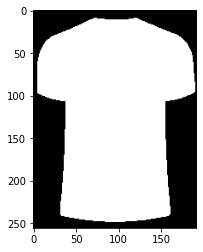

True

In [ ]:
# import the necessary packages
import numpy as np
import argparse
import time
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", type=str,
#	default=os.path.sep.join(["/content/drive/My Drive/Data-Preprocessing-Virtual-Try-On/grabcut-product-images", "s-1.jpg"]),
#	help="path to input image that we'll apply GrabCut to")
#ap.add_argument("-c", "--iter", type=int, default=10,
#	help="# of GrabCut iterations (larger value => slower runtime)")
#args = vars(ap.parse_args())

# load the input image from disk and then allocate memory for the
# output mask generated by GrabCut -- this mask should hae the same
# spatial dimensions as the input image
#image = cv2.imread(args["image"])
image = cv2.imread('/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/cloth_image/s-2.jpg')
mask = np.zeros(image.shape[:2], dtype="uint8")

# define the bounding box coordinates that approximately define my
# face and neck region (i.e., all visible skin)
rect = (5,5,187,256)

# allocate memory for two arrays that the GrabCut algorithm internally
# uses when segmenting the foreground from the background
fgModel = np.zeros((1, 65), dtype="float")
bgModel = np.zeros((1, 65), dtype="float")
# apply GrabCut using the the bounding box segmentation method
start = time.time()
(mask, bgModel, fgModel) = cv2.grabCut(image, mask, rect, bgModel,
	fgModel, iterCount=10, mode=cv2.GC_INIT_WITH_RECT)
end = time.time()
print("[INFO] applying GrabCut took {:.2f} seconds".format(end - start))

# the output mask has for possible output values, marking each pixel
# in the mask as (1) definite background, (2) definite foreground,
# (3) probable background, and (4) probable foreground
#values = (
#	("Definite Background", cv2.GC_BGD),
#	("Probable Background", cv2.GC_PR_BGD),
#	("Definite Foreground", cv2.GC_FGD),
#	("Probable Foreground", cv2.GC_PR_FGD),
#)
# loop over the possible GrabCut mask values
#for (name, value) in values:
	# construct a mask that for the current value
#	print("[INFO] showing mask for '{}'".format(name))
#	valueMask = (mask == value).astype("uint8") * 255
	# display the mask so we can visualize it
#	plt.imshow(cv2.cvtColor(valueMask,cv2.COLOR_BGR2RGB))
#	plt.show()

# we'll set all definite background and probable background pixels
# to 0 while definite foreground and probable foreground pixels are
# set to 1
#outputMask = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD),	0, 1)
# scale the mask from the range [0, 1] to [0, 255]
#outputMask = (outputMask * 255).astype("uint8")

# apply a bitwise AND to the image using our mask generated by
# GrabCut to generate our final output image

#output = cv2.bitwise_and(image, image, mask=outputMask)
#plt.imshow(cv2.cvtColor(output,cv2.COLOR_BGR2RGB))
#plt.show()

value = cv2.GC_PR_FGD
valueMask = (mask == value).astype(np.float32) * 255
plt.imshow(cv2.cvtColor(valueMask,cv2.COLOR_BGR2RGB))

plt.show()
#cv2.imwrite('/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/cloth_mask/AS121D04B-W11@12=cloth_front_mask.png',cv2.cvtColor(valueMask,cv2.COLOR_BGR2RGB))
thresh=128
img_binary = cv2.threshold(valueMask, thresh, 255, cv2.THRESH_BINARY)[1]
#cv2.imwrite('/content/AS121D04B-W11@12=cloth_front_mask.png',img_binary) 
cv2.imwrite('/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/cloth_mask/s-2_mask.png',img_binary) 

# Working Virtual Try-On Model

In [ ]:
#DEMO
%cd '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/'
!sh demo.sh

/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving
Running forward
+ CUDA_VISIBLE_DEVICES=0 python demo.py --batch_size_v 80 --num_workers 4 --forward_save_path demo/forward
Namespace(G_GAN=1, G_VGG=1, G_nn=1, batch_size_t=128, batch_size_v=80, beta1=0.5, dataroot=False, dataset='MPV', dataset_mode='regular', decay_iters=10, epoch=200, face_L1=10, face_gan=3, face_img_L1=1, face_residual=False, face_vgg=1, fine_height=256, fine_width=192, forward='normal', forward_save_path='demo/forward', gan_mode='lsgan', gpu_ids=[0, 1, 2, 3], grid_size=5, init_gain=0.02, init_type='normal', input_nc_D_app=6, input_nc_D_face=6, input_nc_D_parsing=56, input_nc_G_app=26, input_nc_G_face=6, input_nc_G_parsing=36, isdemo=False, isval=False, joint=False, joint_G_parsing=1, joint_all=False, joint_parse_loss=False, lambda_L1=1, lr=0.0002, mask=1, mask_tvloss=False, momentum=0.9, n_layers_D=3, ndf=64, netD_app='resnet_blocks', netD_face='resnet_blocks', ne

# Test Pipeline: 
input: (person image, cloth image, target pose)
output: (warped image1, warped image2(refined))





In [ ]:
#####################
#####################
'''
1. resize images to (256,192): all target, source, cloth (3 outputs)
2. get json output for target pose (1 output)
3. perform semantic parsing for source image: you also need to write the text files val, val_id (2 outputs)
4. generate cloth mask (1 output)

5. copy images to dataset folder of down to the last detail...
6. run working vton, you aso need to write the text file demo.txt
7. get the outputs from forward/out, and forward/out-refined
'''
#####################
#####################


import PIL
import numpy as np
import argparse
import time
import cv2
import os
import numpy as np
import json 
import imageio as ii
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

def resizer_person_vton(file_path):
  image = PIL.Image.open(file_path)
  resized_image = image.resize((192,256),PIL.Image.LANCZOS)
  return_path = '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/images/{}.jpg'.format((file_path.split('/')[-1]).split('.')[0])
  resized_image.save('/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/images/{}.jpg'.format((file_path.split('/')[-1]).split('.')[0]))
  return return_path

def resizer_cloth_vton(file_path):
#returns paths of resized images
  image = PIL.Image.open(file_path)
  resized_image = image.resize((192,256),PIL.Image.LANCZOS)
  return_path = '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/cloth_image/{}.jpg'.format((file_path.split('/')[-1]).split('.')[0])
  resized_image.save('/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/cloth_image/{}.jpg'.format((file_path.split('/')[-1]).split('.')[0]))
  return return_path









def hrnet_vton(file_path):
  #Working Directory
  %cd '/content/drive/My Drive/Eroom-models-working/simple-HRNet'
  import cv2
  from SimpleHRNet import SimpleHRNet
  import pandas as pd
  import numpy as np


  #Run Simple-HRNET
  model = SimpleHRNet(48, 17, "./weights/pose_hrnet_w48_384x288.pth")
  img=cv2.imread(file_path)
  #img1=cv2.resize(img, (192,256), cv2.INTER_CUBIC)
  joints = model.predict(img)


  #### Input: HRNET joints, OUTPUT: Openpose Json
  raw_joints = pd.DataFrame(joints[0])#input
  columns_titles = [1,0]
  raw_joints2=raw_joints.reindex(columns=columns_titles)
  raw_joints2 = pd.concat([raw_joints2,raw_joints[2]], axis=1)
  raw_joints2

  openpose_json = pd.DataFrame(raw_joints2.iloc[0]).T
  x_av = (raw_joints2.loc[5,1] +  raw_joints2.loc[6,1])/2
  y_av = (raw_joints2.loc[5,0] +  raw_joints2.loc[6,0])/2
  z_av = (raw_joints2.loc[5,2] +  raw_joints2.loc[6,2])/2

  openpose_json=openpose_json.append({1:x_av,0:y_av,2:z_av},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[6,1],0:raw_joints2.loc[6,0],2:raw_joints2.loc[6,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[8,1],0:raw_joints2.loc[8,0],2:raw_joints2.loc[8,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[10,1],0:raw_joints2.loc[10,0],2:raw_joints2.loc[10,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[5,1],0:raw_joints2.loc[5,0],2:raw_joints2.loc[5,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[7,1],0:raw_joints2.loc[7,0],2:raw_joints2.loc[7,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[9,1],0:raw_joints2.loc[9,0],2:raw_joints2.loc[9,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[12,1],0:raw_joints2.loc[12,0],2:raw_joints2.loc[12,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[14,1],0:raw_joints2.loc[14,0],2:raw_joints2.loc[14,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[16,1],0:raw_joints2.loc[16,0],2:raw_joints2.loc[16,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[11,1],0:raw_joints2.loc[11,0],2:raw_joints2.loc[11,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[13,1],0:raw_joints2.loc[13,0],2:raw_joints2.loc[13,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[15,1],0:raw_joints2.loc[15,0],2:raw_joints2.loc[15,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[2,1],0:raw_joints2.loc[2,0],2:raw_joints2.loc[2,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[1,1],0:raw_joints2.loc[1,0],2:raw_joints2.loc[1,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[4,1],0:raw_joints2.loc[4,0],2:raw_joints2.loc[4,2]},ignore_index=True)
  openpose_json=openpose_json.append({1:raw_joints2.loc[3,1],0:raw_joints2.loc[3,0],2:raw_joints2.loc[3,2]},ignore_index=True)

  input_json = openpose_json.to_numpy().flatten().tolist() #output, openpose coco keypoints

  import json 
  %cd '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/pose_coco'
  # Data to be written 
  dictionary ={ 
  "version":1.3,"people":[{"person_id":[-1],"pose_keypoints_2d":input_json,"face_keypoints_2d":[],"hand_left_keypoints_2d":[],"hand_right_keypoints_2d":[],"pose_keypoints_3d":[],"face_keypoints_3d":[],"hand_left_keypoints_3d":[],"hand_right_keypoints_3d":[]}]
  } 
  # Serializing json  
  json_object = json.dumps(dictionary) 
    
  # Writing to sample.json 
  with open("{}_keypoints.json".format((file_path.split('/')[-1]).split('.')[0]), "w") as outfile: #json output file
      outfile.write(json_object) 
  json_path = '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/pose_coco/{}_keypoints.json'.format((file_path.split('/')[-1]).split('.')[0])
  return json_path






def semantic_parsing_input_vton(file_path):
  %cd '/content/drive/My Drive/Eroom-models-working/$HOME'
  #Run matplotlib script to produce labels, and edges from new source image in datasets/CIHP/images/
  import numpy as np
  import imageio as ii
  from PIL import Image
  import matplotlib.pyplot as plt
  %matplotlib inline
  print(file_path)
  dst = "/content/drive/My Drive/Eroom-models-working/$HOME/datasets/CIHP/images/{}".format(file_path.split('/')[-1])
  from shutil import copyfile
  copyfile(file_path, dst)

  nxb_img   = Image.open('/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/images/{}.jpg'.format((file_path.split('/')[-1]).split('.')[0]))      # This is your image.
  
  # Reshape their label image to our size 

  label_img = Image.open('datasets/CIHP/edges/0012008.png')  # This is the label image from CIHP.
  nxb_label_img = label_img.resize(nxb_img.size, Image.NEAREST)
  nxb_label_img.save('datasets/CIHP/labels/{}.png'.format((file_path.split('/')[-1]).split('.')[0]))

  # Reshape their edge image to our size 
  edge_img  = Image.open('/content/drive/My Drive/Eroom-models-working/$HOME/datasets/CIHP/edges/0012008.png')
  nxb_edge_img  = edge_img.resize(nxb_img.size, Image.NEAREST)
  nxb_edge_img.save('datasets/CIHP/edges/{}.png'.format((file_path.split('/')[-1]).split('.')[0]))







def semantic_parsing_model_vton(file_path):
  %cd '/content/drive/My Drive/Eroom-models-working/$HOME'
  %tensorflow_version 1.x
  !python test_pgn.py
  f1 = '/content/drive/My Drive/Eroom-models-working/$HOME/output/cihp_parsing_maps/{}.png'.format((file_path.split('/')[-1]).split('.')[0])
  f11 =  '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/parse_cihp/{}.png'.format((file_path.split('/')[-1]).split('.')[0])
  f2 = '/content/drive/My Drive/Eroom-models-working/$HOME/output/cihp_parsing_maps/{}_vis.png'.format((file_path.split('/')[-1]).split('.')[0]) 
  f22= '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/parse_cihp/{}_vis.png'.format((file_path.split('/')[-1]).split('.')[0])
  from shutil import copyfile
  copyfile(f1,f11)
  copyfile(f2,f22)

def cloth_mask_vton(file_path):
  image = cv2.imread(file_path)
  mask = np.zeros(image.shape[:2], dtype="uint8")
  rect = (5,5,187,256)
  fgModel = np.zeros((1, 65), dtype="float")
  bgModel = np.zeros((1, 65), dtype="float")
  # apply GrabCut using the the bounding box segmentation method
  (mask, bgModel, fgModel) = cv2.grabCut(image, mask, rect, bgModel,fgModel, iterCount=10, mode=cv2.GC_INIT_WITH_RECT)
  value = cv2.GC_PR_FGD
  valueMask = (mask == value).astype(np.float32) * 255
  thresh=128
  img_binary = cv2.threshold(valueMask, thresh, 255, cv2.THRESH_BINARY)[1]
  cv2.imwrite('/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/cloth_mask/{}_mask.png'.format((file_path.split('/')[-1]).split('.')[0]),img_binary)


#return path to cloth mask 
def working_vton():
  #DEMO
  %cd '/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/'
  !sh demo.sh

def show_output_vton():
  from PIL import Image
  image = Image.open('/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/demo/forward/out/0.jpg')
  plt.imshow(image)
  plt.show()
  image = Image.open('/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/demo/forward/out/0.jpg')
  plt.imshow(image)
  plt.show()



#text files writer
def val_writer(file_path):
  f = open('/content/drive/MyDrive/Eroom-models-working/$HOME/datasets/CIHP/list/val.txt',"w")
  f.write("/images/{}.jpg /labels/{}.png".format((file_path.split('/')[-1]).split('.')[0],(file_path.split('/')[-1]).split('.')[0]))
  f.close()

def val_id_writer(file_path):
  f = open('/content/drive/MyDrive/Eroom-models-working/$HOME/datasets/CIHP/list/val_id.txt',"w")
  f.write((file_path.split('/')[-1]).split('.')[0])
  f.close()
def demo_writer(source_path, cloth_path, json_path):
  f = open('/content/drive/MyDrive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/demo/demo.txt',"w")
  f.write(source_path.split('/')[-1]+" "+json_path.split('/')[-1]+" "+cloth_path.split('/')[-1]+" test")
  f.close()



def vton_model(person_image_path, cloth_image_path):
  start = time.time()
  source_path = resizer_person_vton(person_image_path)#done
  cloth_path = resizer_cloth_vton(cloth_image_path)#done
  end1 = time.time()
  json_path = hrnet_vton(source_path)#done
  end2 = time.time()
  cloth_mask_vton(cloth_path)#done
  end3 = time.time()
  semantic_parsing_input_vton(source_path)#done
  val_writer(source_path)
  val_id_writer(source_path)
  end4 = time.time()
  semantic_parsing_model_vton(source_path)#done
  end5 = time.time()
  demo_writer(source_path, cloth_path, json_path)
  working_vton()#done
  end6 = time.time()
  show_output_vton()#done
  end = time.time()
  print("Resizing took {:.2f} seconds".format(end1 - start))
  print("HRNet took {:.2f} seconds".format(end2 - end1))
  print("Cloth Masking took {:.2f} seconds".format(end3 - end2))
  print("Semantic Parsing Input Prep took {:.2f} seconds".format(end4-end3))
  print("Semantic Parsing Model {:.2f} seconds".format(end5-end4))
  print("VTON Model took {:.2f} seconds".format(end6-end5))  
  print("Model took {:.2f} seconds".format(end - start))



  








  


/content/drive/.shortcut-targets-by-id/298/simple-HRNet
device: 'cpu'
/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/pose_coco
/content/drive/My Drive/Eroom-models-working/$HOME
/content/drive/My Drive/Eroom-models-working/Down-to-the-Last-Detail-Virtual-Try-on-with-Detail-Carving/dataset/images/img_00000009.jpg
/content/drive/My Drive/Eroom-models-working/$HOME
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repe

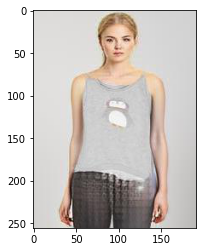

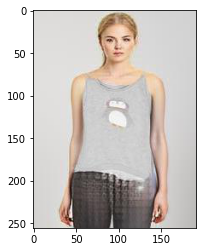

Resizing took 0.06 seconds
HRNet took 17.38 seconds
Cloth Masking took 0.35 seconds
Semantic Parsing Input Prep took 0.03 seconds
Semantic Parsing Model 38.61 seconds
VTON Model took 10.77 seconds
Model took 67.49 seconds


In [ ]:
image_path = '/content/img_00000009.jpg'
cloth_path = '/content/s-3.jpg'
vton_model(image_path,cloth_path)